### This notebook is the first draft on the use of GANs, it is here to present the approach

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from GAN_function import *
from implementations import *
 
#to access our implemented ML functions
%load_ext autoreload
%autoreload 2

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
rng = np.random.default_rng(2022)

## Sanity check

In [14]:
data_path = data_file(20.0) # Retrieve datafile

In [15]:
data = clean_df(build_df(data_path))

In [16]:
data = data.loc[data['name_s'] != 0] # Get elements without emission

In [17]:
data = get_angles(data) # Create all angles

In [18]:
data.head()

,index,X(mm),Y(mm),Z(mm),DX,DY,DZ,KinE(MeV),dE(MeV),StepLeng,...,Y(mm)_s,Z(mm)_s,DX_s,DY_s,DZ_s,Kin(MeV)_s,name_s,cos_phi,cos_theta,cos_psi
1,1,4.12,99.8,100.0,0.987,-0.16000,-0.0122,18.40,0.5630,4.120,...,99.8,100.0,0.802,0.592,0.0804,1.0700,e-,0.695873,0.997879,0.645309
2,2,8.26,99.1,100.0,0.974,-0.22700,-0.0181,17.60,0.6210,4.220,...,99.1,100.0,0.506,0.811,-0.2930,0.1190,e-,0.314050,0.985838,0.174330
4,4,14.60,97.8,100.0,0.937,-0.33100,0.1070,11.60,0.3110,1.690,...,97.8,100.0,0.987,0.133,-0.0869,4.8900,e-,0.871498,0.960117,0.729625
6,6,19.50,96.1,101.0,0.829,-0.44400,0.3400,10.60,0.0663,0.593,...,96.1,101.0,0.801,-0.496,0.3350,0.2260,gamma,0.998153,0.826920,0.804041
11,11,34.30,92.3,113.0,0.702,-0.00649,0.7120,7.39,0.0633,0.468,...,92.3,113.0,0.844,0.267,-0.4640,0.0852,e-,0.260387,0.571937,-0.205534


## Prepare torch tensor for ML processing

In [19]:
# Here we build function to extract the data to feed the first GAN
def first_data(df):
    df = df.copy(deep=True)
    df = df.loc[df['name_s'] == 0]
    df = df[['cos_theta','dE(MeV)','StepLeng']]
    df = df.to_numpy()
    return df

In [20]:
data_path = data_file(20.0)

In [21]:
data = first_data(get_cos_theta(clean_df(build_df(data_path))))

In [22]:
data[:5]

array([[0.987     , 0.        , 0.        ],
       [0.98255922, 0.779     , 4.78      ],
       [0.999542  , 0.701     , 4.75      ],
       [0.945264  , 0.7       , 4.35      ],
       [0.984864  , 0.77      , 5.26      ]])

In [23]:
np.isnan(data).sum() #Sanity check

0

### This should create a generator from our dataset

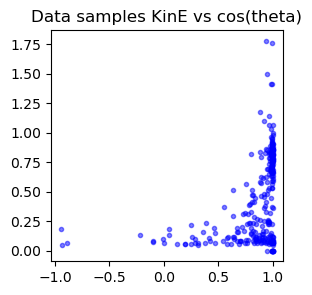

In [24]:
data_generator = inf_data_gen(dataset=data, batch_size=300)
sample = next(data_generator)
plt.figure(figsize=(3, 3))
plt.scatter(sample[:, 0], sample[:, 1], c="blue", marker=".", alpha=0.5)
plt.title("Data samples KinE vs cos(theta)")
plt.show()

In [25]:
# @title Setup
# Learning rate of the generator:
g_lr = 1e-4  # @param {type:"number",  min:0.000001}
# Learning rate of the discriminator:
d_lr = 5e-4  # @param {type:"number",  min:0.000001}
# batch size:
batch_size = 64  # @param {type:"integer",  min:1}
# dimension of tha latent vector
noise_dim = 100  # @param {type:"integer",  min:1}
# number of training iterations
total_iterations = 5000  # @param {type:"slider", min:1, max:50000, step:1}

## Let's train every GAN
First GAN : dataset = no-emission  and  $0< E<7.8$ MeV.

In [26]:
data_path = data_file(20.0)

In [27]:
data1, data2 = GAN1_data(data_path) #Build the data for the GAN for the no-emission type interaction

Dataset is loaded and ready for process, let's see what to expect for different variables.

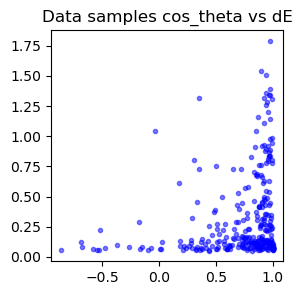

In [28]:
# ID for each variable
name_var = {'cos_theta': 0, 'dE': 1}

# What variable to plot

var_x = 'cos_theta'
var_y = 'dE'
plot_x = name_var[var_x]
plot_y = name_var[var_y]


data_generator = inf_data_gen(dataset=data1, batch_size=300)
sample = next(data_generator)
plt.figure(figsize=(3, 3))
plt.scatter(sample[:, plot_x], sample[:, plot_y], c="blue", marker=".", alpha=0.5)
plt.title("Data samples " + var_x + " vs " + var_y)
plt.show()

In [29]:
# We build the GAN architecture
criterion = nn.BCELoss()  # Binary cross entropy

g_model = GeneratorMLP(dim_hidden=128, dim_out=2, noise_dim=noise_dim)
d_model = DiscriminatorMLP(dim_hidden=128, dim_gen_out=2)
print(g_model)
print(d_model)

GeneratorMLP(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)
DiscriminatorMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [30]:
# Use `launch_GAN` function to generate all the fake_samples at each epoch of training

fake_samples1 = launch_GAN(g_lr=g_lr, d_lr=d_lr, batch_size=batch_size, noise_dim=noise_dim,\
                          total_iterations=total_iterations, criterion=criterion, data=data1,\
                          g_model=g_model, d_model=d_model)

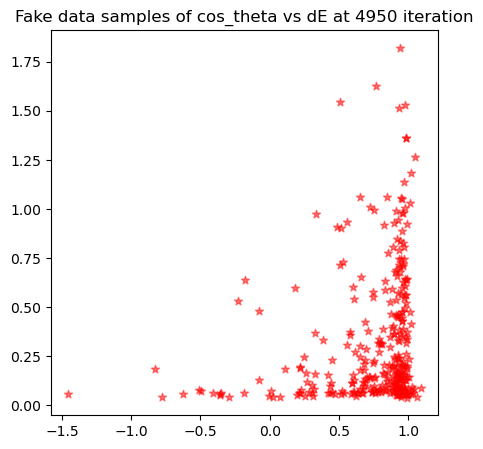

In [31]:
# ID for each variable
name_var = {'cos_theta': 0, 'dE': 1}

# What variable to plot

var_x = 'cos_theta'
var_y = 'dE'
plot_x = name_var[var_x]
plot_y = name_var[var_y]

plot_frequency = total_iterations // 100
iteration_plot_generator_samples = 99  # @param {type:"slider", min:0, max:100, step:1}
fake_sample = fake_samples1[iteration_plot_generator_samples]
plt.figure(figsize=(5, 5))
plt.scatter(fake_sample[:, plot_x], fake_sample[:, plot_y], c="red", marker="*", alpha=0.5)
plt.title(
    f"Fake data samples of {var_x} vs {var_y} at {iteration_plot_generator_samples*plot_frequency} iteration"
)
plt.show()

### Cross Matrix of Predicted variable 

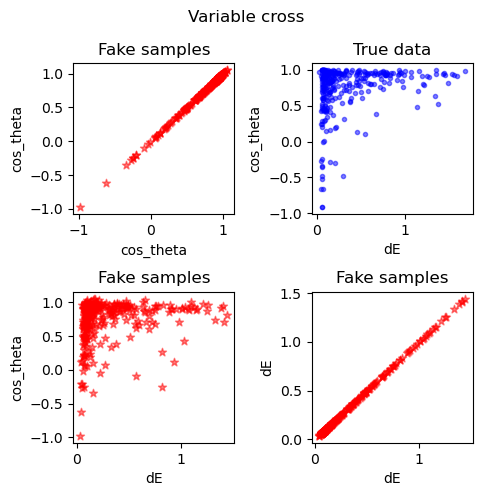

In [36]:
name_var = {'cos_theta': 0, 'dE': 1}
list_name = list(name_var)

N_variable = fake_sample.shape[1]
fig, axs = plt.subplots(N_variable, N_variable, figsize=(5, 5))
fig.suptitle('Variable cross')
for j in range(N_variable):
    for i in range(N_variable):
        if i >= j:
            axs[i,j].scatter(fake_sample[:,i], fake_sample[:,j], c="red", marker="*", alpha=0.5)
            axs[i,j].set_xlabel(list_name[i])
            axs[i,j].set_ylabel(list_name[j])
            axs[i,j].set_title('Fake samples')
        else:
            axs[i,j].scatter(sample[:, j], sample[:, i], c="blue", marker=".", alpha=0.5)
            axs[i,j].set_xlabel(list_name[j])
            axs[i,j].set_ylabel(list_name[i])
            axs[i,j].set_title('True data')
fig.tight_layout(pad=1)

It seems to work properly

## Now the SECOND DAN
Second GAN : dataset = no-emission  and  $7.8< E<20$ MeV.

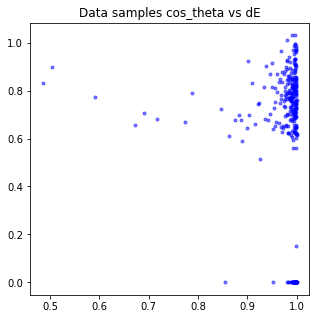

In [92]:
# ID for each variable
name_var = {'cos_theta': 0, 'dE': 1}

# What variable to plot

var_x = 'cos_theta'
var_y = 'dE'
plot_x = name_var[var_x]
plot_y = name_var[var_y]

# This time data2
data_generator = inf_data_gen(dataset=data2, batch_size=300)
sample = next(data_generator)
plt.figure(figsize=(5, 5))
plt.scatter(sample[:, plot_x], sample[:, plot_y], c="blue", marker=".", alpha=0.5)
plt.title("Data samples " + var_x + " vs " + var_y)
plt.show()

We launch the GAN with the corresponding dataset

In [93]:
fake_samples2 = launch_GAN(g_lr=g_lr, d_lr=d_lr, batch_size=batch_size, noise_dim=noise_dim,\
                          total_iterations=total_iterations, criterion=criterion, data=data2,\
                          g_model=g_model, d_model=d_model)

We plot the different variables it predicts

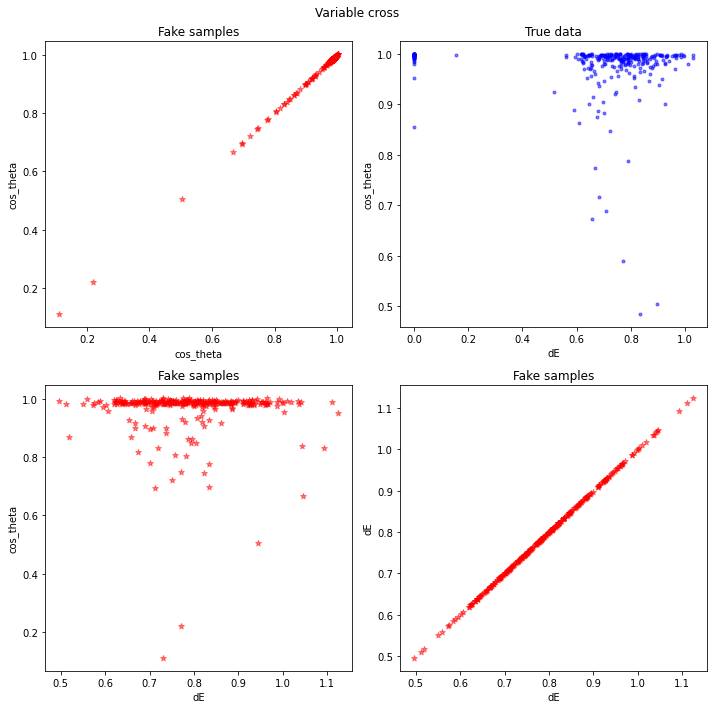

In [95]:
name_var = {'cos_theta': 0, 'dE': 1}
list_name = list(name_var)

plot_frequency = total_iterations // 100
iteration_plot_generator_samples = 99  # @param {type:"slider", min:0, max:100, step:1}
fake_sample = fake_samples2[iteration_plot_generator_samples]

N_variable = fake_sample.shape[1]
fig, axs = plt.subplots(N_variable, N_variable, figsize=(10, 10))
fig.suptitle('Variable cross')
for j in range(N_variable):
    for i in range(N_variable):
        if i >= j:
            axs[i,j].scatter(fake_sample[:,i], fake_sample[:,j], c="red", marker="*", alpha=0.5)
            axs[i,j].set_xlabel(list_name[i])
            axs[i,j].set_ylabel(list_name[j])
            axs[i,j].set_title('Fake samples')
        else:
            axs[i,j].scatter(sample[:, j], sample[:, i], c="blue", marker=".", alpha=0.5)
            axs[i,j].set_xlabel(list_name[j])
            axs[i,j].set_ylabel(list_name[i])
            axs[i,j].set_title('True data')
fig.tight_layout(pad=1)

## Now the THIRD GAN
Third GAN : dataset = e- emission  and  $0< E<1$ MeV.

In [5]:
data3, data4 = GAN2_data(data_path)

In [6]:
data_generator = inf_data_gen(dataset=data3, batch_size=300)
sample = next(data_generator)

In [7]:
data3[:3]

array([[ 0.4518004,  0.118    ,  0.233566 , -0.576599 ,  0.896    ],
       [-0.6773574,  0.134    ,  0.2839167, -0.775459 ,  0.47     ],
       [ 0.7547224,  0.206    ,  0.3286638,  0.797408 ,  0.84     ]])

In [8]:
name_var = {'cos_theta': 0, 'dE': 1, 'cos_phi': 2, 'cos_psi': 3, 'E_s': 4}
list_name = list(name_var)

In [9]:
dim_out = len(list_name)

In [326]:
g_model2 = GeneratorMLP(dim_hidden=128, dim_out=dim_out, noise_dim=noise_dim)
d_model2 = DiscriminatorMLP(dim_hidden=128, dim_gen_out=dim_out)
print(g_model2)
print(d_model2)

GeneratorMLP(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=5, bias=True)
  )
)
DiscriminatorMLP(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [13]:
fake_samples3 = launch_GAN(g_lr=g_lr, d_lr=d_lr, batch_size=batch_size, noise_dim=noise_dim,\
                          total_iterations=total_iterations, criterion=criterion, data=data3,\
                          g_model=g_model2, d_model=d_model2)

We extract the fake samples at the end of the iterations

In [14]:
plot_frequency = total_iterations // 100
iteration_plot_generator_samples = 99  # @param {type:"slider", min:0, max:100, step:1}
fake_sample = fake_samples3[iteration_plot_generator_samples]

In [15]:
# Build dataframe for seaborn plot

fake_df = pd.DataFrame(columns=list_name,data=fake_sample)
true_df = pd.DataFrame(columns=list_name,data=sample)

In [16]:
true_df.head()

,cos_theta,dE,cos_phi,cos_psi,E_s
0,-0.394013,0.0750,0.127820,0.286925,0.164
1,-0.180968,0.2060,0.353306,-0.149985,0.835
2,0.381605,0.1830,0.223805,0.520638,0.970
3,0.678357,0.1130,0.182634,0.549764,0.582
4,0.647996,0.0767,0.294188,0.748203,0.865


### Cross matrix of the predicted variable for this model (Real vs Fake samples)

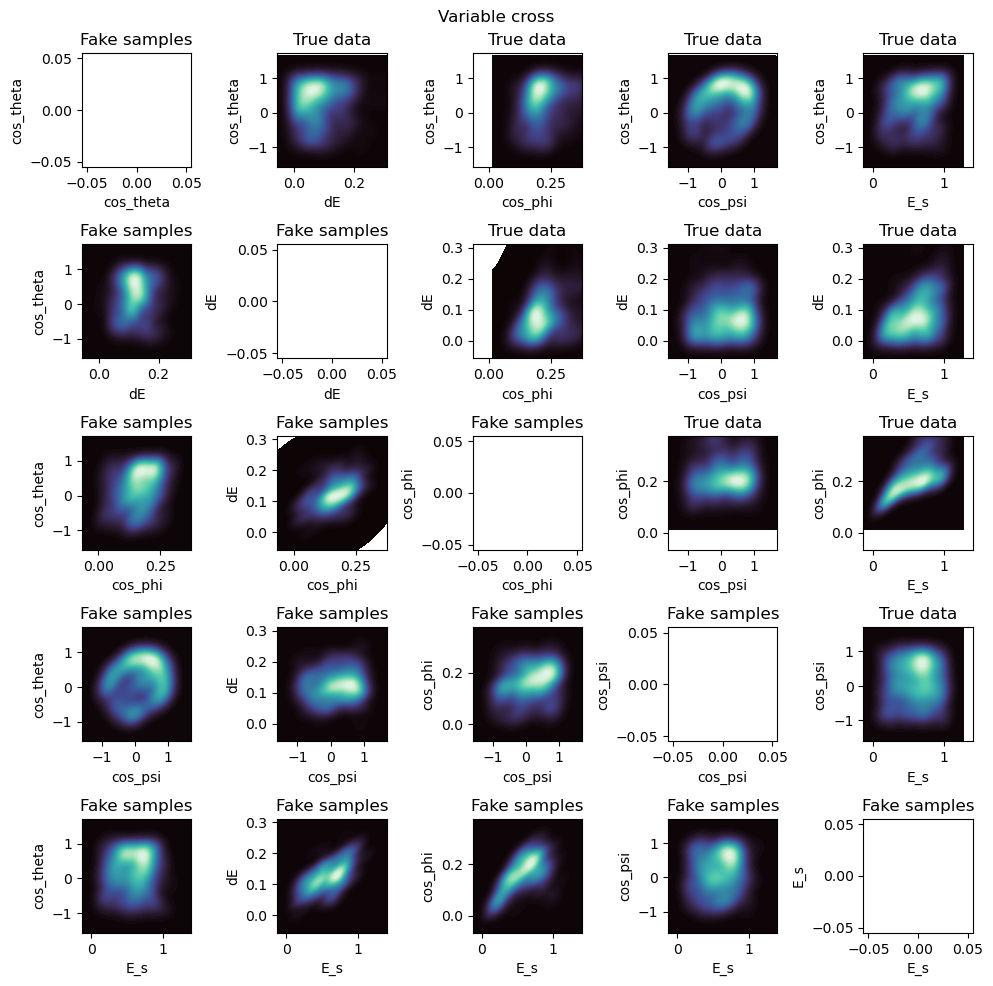

In [21]:
N_variable = fake_sample.shape[1]
fig, axs = plt.subplots(N_variable, N_variable, figsize=(10, 10))
fig.suptitle('Variable cross')
for j in range(N_variable):
    for i in range(N_variable):
        if i >= j:
            #sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        #cmap="Reds", shade=True)
            sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(fake_sample[:,i], fake_sample[:,j], c="red", marker="*", alpha=0.5)
            axs[i,j].set_xlabel(list_name[i])
            axs[i,j].set_ylabel(list_name[j])
            axs[i,j].set_title('Fake samples')
        else:
            sns.kdeplot(data=true_df, ax=axs[i,j], x=list_name[j], y=list_name[i],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(sample[:, j], sample[:, i], c="blue", marker=".", alpha=0.5)
            axs[i,j].sharex(axs[j,i])
            axs[i,j].sharey(axs[j,i])
            axs[i,j].set_xlabel(list_name[j])
            axs[i,j].set_ylabel(list_name[i])
            axs[i,j].set_title('True data')
fig.tight_layout(pad=1)

## Now the FOURTH GAN
Fourth GAN : dataset = e- emission  and  $1< E<20$ MeV.

In [22]:
data_generator = inf_data_gen(dataset=data4, batch_size=300)
sample = next(data_generator)

In [23]:
data4[:3]

array([[ 0.99787882,  0.563     ,  0.69587312,  0.64530876, 18.4       ],
       [ 0.9858383 ,  0.621     ,  0.3140503 ,  0.17433   , 17.6       ],
       [ 0.73610619,  0.311     ,  0.8714977 ,  0.63013803, 11.6       ]])

In [24]:
name_var = {'cos_theta': 0, 'dE': 1, 'cos_phi': 2, 'cos_psi': 3, 'E_s': 4}
list_name = list(name_var)

In [25]:
dim_out = len(list_name)

In [26]:
fake_samples4 = launch_GAN(g_lr=g_lr, d_lr=d_lr, batch_size=batch_size, noise_dim=noise_dim,\
                          total_iterations=total_iterations, criterion=criterion, data=data4,\
                          g_model=g_model2, d_model=d_model2)

In [14]:
plot_frequency = total_iterations // 100
iteration_plot_generator_samples = 99  # @param {type:"slider", min:0, max:100, step:1}
fake_sample = fake_samples4[iteration_plot_generator_samples]

In [15]:
# Build dataframe for seaborn plot

fake_df = pd.DataFrame(columns=list_name,data=fake_sample)
true_df = pd.DataFrame(columns=list_name,data=sample)

In [16]:
true_df.head()

,cos_theta,dE,cos_phi,cos_psi,E_s
0,-0.394013,0.0750,0.127820,0.286925,0.164
1,-0.180968,0.2060,0.353306,-0.149985,0.835
2,0.381605,0.1830,0.223805,0.520638,0.970
3,0.678357,0.1130,0.182634,0.549764,0.582
4,0.647996,0.0767,0.294188,0.748203,0.865


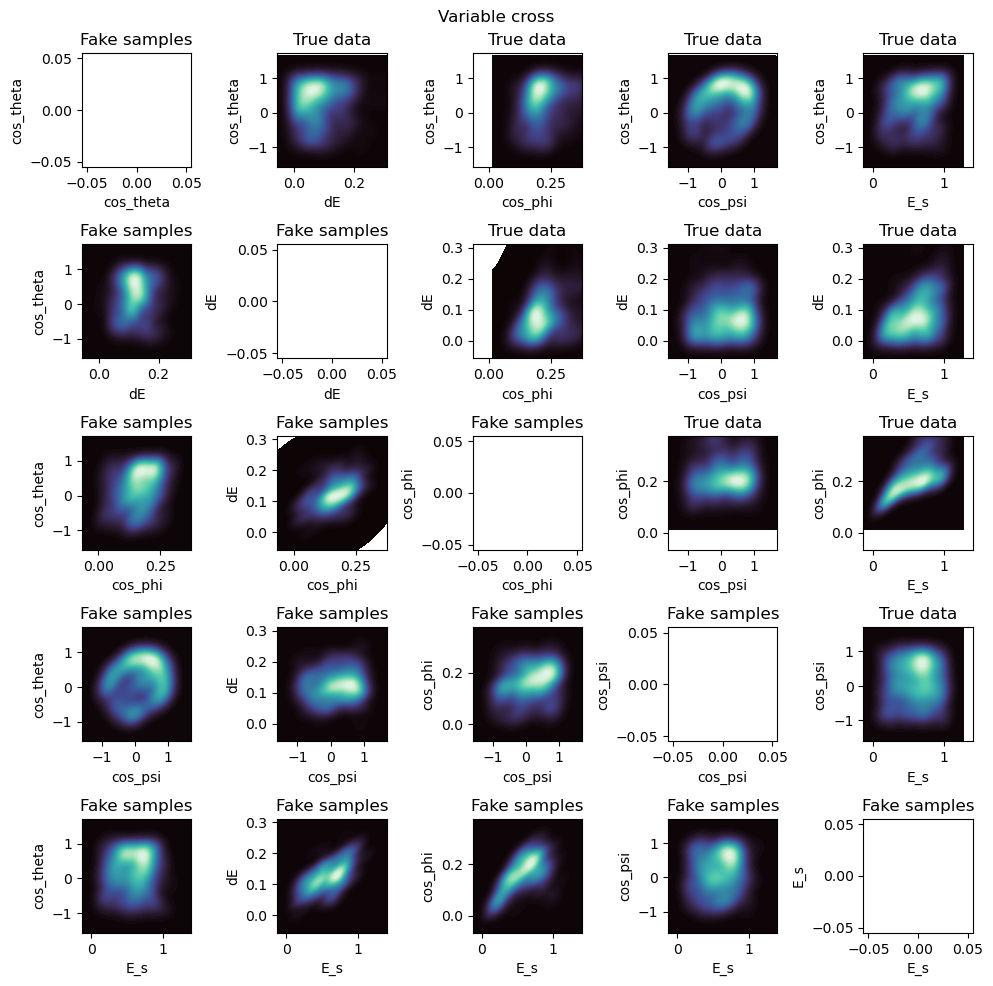

In [21]:
N_variable = fake_sample.shape[1]
fig, axs = plt.subplots(N_variable, N_variable, figsize=(10, 10))
fig.suptitle('Variable cross')
for j in range(N_variable):
    for i in range(N_variable):
        if i >= j:
            #sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        #cmap="Reds", shade=True)
            sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(fake_sample[:,i], fake_sample[:,j], c="red", marker="*", alpha=0.5)
            axs[i,j].set_xlabel(list_name[i])
            axs[i,j].set_ylabel(list_name[j])
            axs[i,j].set_title('Fake samples')
        else:
            sns.kdeplot(data=true_df, ax=axs[i,j], x=list_name[j], y=list_name[i],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(sample[:, j], sample[:, i], c="blue", marker=".", alpha=0.5)
            axs[i,j].sharex(axs[j,i])
            axs[i,j].sharey(axs[j,i])
            axs[i,j].set_xlabel(list_name[j])
            axs[i,j].set_ylabel(list_name[i])
            axs[i,j].set_title('True data')
fig.tight_layout(pad=1)

## Now the FIFTH GAN
Fifth GAN : dataset = gamma emission  and  $0< E<1$ MeV.

In [7]:
data5, data6 = GAN3_data(data_path)

In [8]:
data_generator = inf_data_gen(dataset=data5, batch_size=300)
sample = next(data_generator)

In [9]:
data5[:3]

array([[ 0.86376311,  0.0382    , -0.1339375 ,  0.16758408,  0.0951    ],
       [ 0.0913168 ,  0.00547   , -0.497036  , -0.2005468 ,  0.803     ],
       [ 0.0469857 ,  0.181     ,  0.770568  ,  0.472407  ,  0.632     ]])

In [10]:
name_var = {'cos_theta': 0, 'dE': 1, 'cos_phi': 2, 'cos_psi': 3, 'E_s': 4}
list_name = list(name_var)

In [11]:
dim_out = len(list_name)

In [342]:
fake_samples5 = launch_GAN(g_lr=g_lr, d_lr=d_lr, batch_size=batch_size, noise_dim=noise_dim,\
                          total_iterations=total_iterations, criterion=criterion, data=data5,\
                          g_model=g_model2, d_model=d_model2)

In [343]:
plot_frequency = total_iterations // 100
iteration_plot_generator_samples = 99  # @param {type:"slider", min:0, max:100, step:1}
fake_sample = fake_samples5[iteration_plot_generator_samples]

In [344]:
# Build dataframe for seaborn plot

fake_df = pd.DataFrame(columns=list_name,data=fake_sample)
true_df = pd.DataFrame(columns=list_name,data=sample)

In [345]:
true_df.head()

,cos_theta,dE,cos_phi,cos_psi,E_s
0,0.785233,0.1440,0.981172,0.732337,0.903
1,-0.480761,0.0666,0.931323,-0.516435,0.354
2,0.192693,0.1100,0.978016,0.265723,0.775
3,-0.092268,0.0607,0.955076,-0.379587,0.987
4,0.675354,0.0385,0.960565,0.710239,0.985


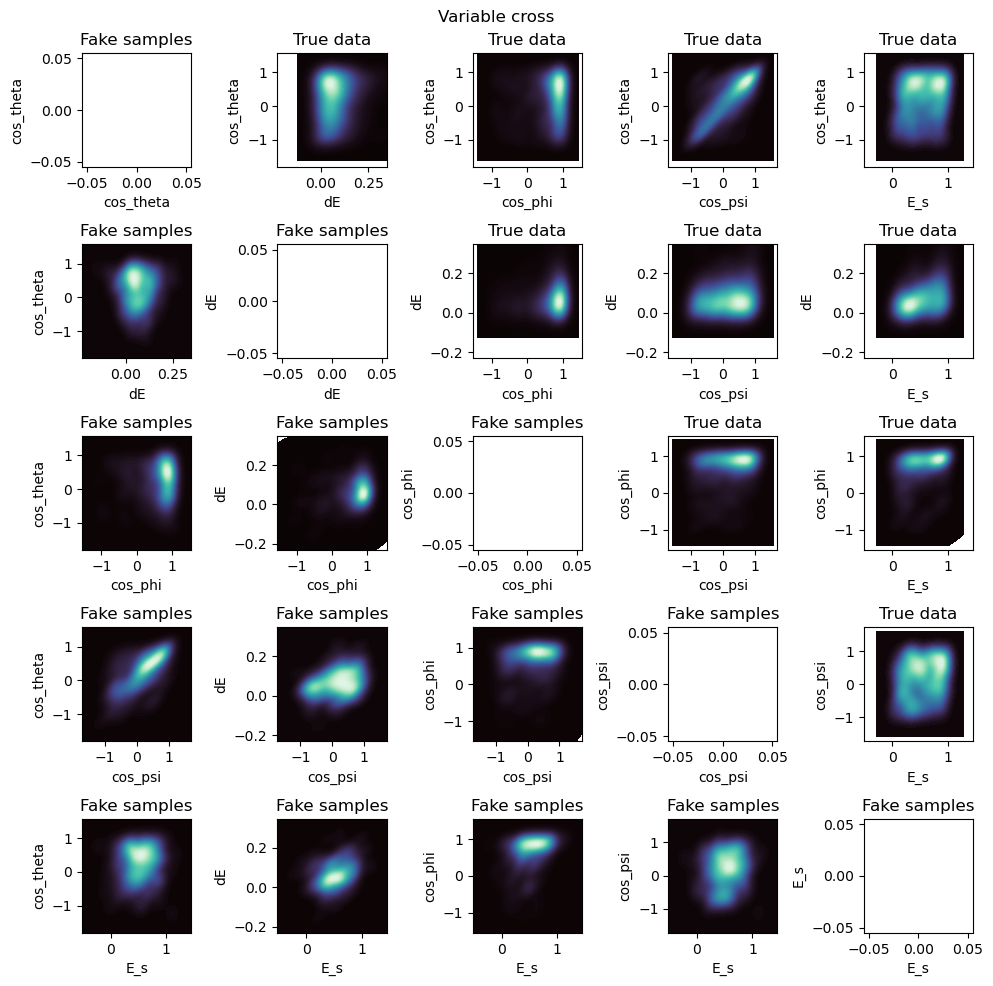

In [346]:
N_variable = fake_sample.shape[1]
fig, axs = plt.subplots(N_variable, N_variable, figsize=(10, 10))
fig.suptitle('Variable cross')
for j in range(N_variable):
    for i in range(N_variable):
        if i >= j:
            #sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        #cmap="Reds", shade=True)
            sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(fake_sample[:,i], fake_sample[:,j], c="red", marker="*", alpha=0.5)
            axs[i,j].set_xlabel(list_name[i])
            axs[i,j].set_ylabel(list_name[j])
            axs[i,j].set_title('Fake samples')
        else:
            sns.kdeplot(data=true_df, ax=axs[i,j], x=list_name[j], y=list_name[i],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(sample[:, j], sample[:, i], c="blue", marker=".", alpha=0.5)
            axs[i,j].sharex(axs[j,i])
            axs[i,j].sharey(axs[j,i])
            axs[i,j].set_xlabel(list_name[j])
            axs[i,j].set_ylabel(list_name[i])
            axs[i,j].set_title('True data')
fig.tight_layout(pad=1)

## Now the SIXTH GAN
Sixth GAN : dataset = gamma emission  and  $1< E<20$ MeV.

In [12]:
data_generator = inf_data_gen(dataset=data6, batch_size=300)
sample = next(data_generator)

In [13]:
data6[:3]

array([[ 0.774428  ,  0.0663    ,  0.998153  ,  0.805832  , 10.6       ],
       [ 0.3477876 ,  0.259     ,  0.246152  ,  0.7851132 ,  3.07      ],
       [ 0.99846401,  0.368     ,  0.9641222 ,  0.95672234, 11.5       ]])

In [14]:
name_var = {'cos_theta': 0, 'dE': 1, 'cos_phi': 2, 'cos_psi': 3, 'E_s': 4}
list_name = list(name_var)

In [15]:
dim_out = len(list_name)

### Let's take a large iteration this time

In [23]:
total_iterations=20000

In [24]:
criterion = nn.BCELoss()  # Binary cross entropy

g_model = GeneratorMLP(dim_hidden=128, dim_out=dim_out, noise_dim=noise_dim)
d_model = DiscriminatorMLP(dim_hidden=128, dim_gen_out=dim_out)
print(g_model)
print(d_model)

GeneratorMLP(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=5, bias=True)
  )
)
DiscriminatorMLP(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [25]:
fake_samples6 = launch_GAN(g_lr=g_lr, d_lr=d_lr, batch_size=batch_size, noise_dim=noise_dim,\
                          total_iterations=total_iterations, criterion=criterion, data=data6,\
                          g_model=g_model, d_model=d_model)

In [27]:
plot_frequency = total_iterations // 100
iteration_plot_generator_samples = 99  # @param {type:"slider", min:0, max:100, step:1}
fake_sample = fake_samples6[iteration_plot_generator_samples]

In [28]:
# Build dataframe for seaborn plot

fake_df = pd.DataFrame(columns=list_name,data=fake_sample)
true_df = pd.DataFrame(columns=list_name,data=sample)

In [29]:
true_df.head()

,cos_theta,dE,cos_phi,cos_psi,E_s
0,0.938515,0.0275,0.997613,0.957729,15.20
1,0.931259,1.2200,0.999795,0.932326,5.17
2,0.912104,0.2850,0.998310,0.930139,14.10
3,0.983887,0.1350,1.000209,0.985888,19.10
4,0.941742,0.3650,0.955818,0.813369,13.70


In [30]:
tips_real = pd.DataFrame(columns=list_name,data=sample)
tips_real['type'] = ['real']*tips_real.shape[0]

tips = tips_real

plot_frequency = total_iterations // 100
iteration_plot_generator_samples=100
fake_sample = fake_samples6[iteration_plot_generator_samples]
tips_fake = pd.DataFrame(columns=list_name,data=fake_sample)
tips_fake['type']=['iteration=' + str(int(plot_frequency*iteration_plot_generator_samples))]\
                                    * fake_sample.shape[0]
tips = pd.concat([tips,tips_fake],ignore_index=True)


### Cross matrix but with distribution of each predicted variable this time

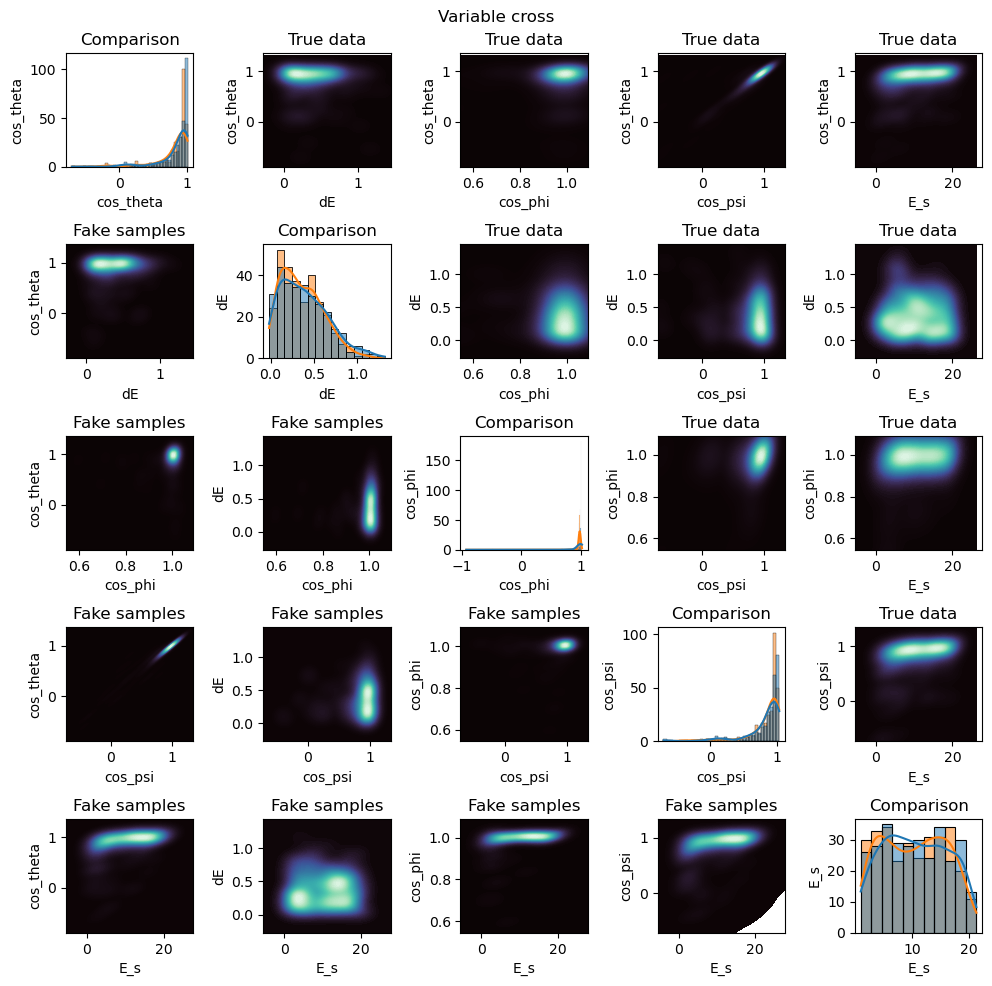

In [31]:
N_variable = fake_sample.shape[1]
fig, axs = plt.subplots(N_variable, N_variable, figsize=(10, 10))
fig.suptitle('Variable cross')
for j in range(N_variable):
    for i in range(N_variable):
        if i > j:
            #sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        #cmap="Reds", shade=True)
            sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(fake_sample[:,i], fake_sample[:,j], c="red", marker="*", alpha=0.5)
            axs[i,j].set_xlabel(list_name[i])
            axs[i,j].set_ylabel(list_name[j])
            axs[i,j].set_title('Fake samples')
        elif(i==j):
            sns.histplot(ax = axs[i,i], data=tips, x=list_name[i], hue='type', legend=False, kde=True)
            axs[i,j].set_xlabel(list_name[i])
            axs[i,j].set_ylabel(list_name[j])
            axs[i,j].set_title('Comparison')
        else:
            sns.kdeplot(data=true_df, ax=axs[i,j], x=list_name[j], y=list_name[i],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(sample[:, j], sample[:, i], c="blue", marker=".", alpha=0.5)
            axs[i,j].sharex(axs[j,i])
            axs[i,j].sharey(axs[j,i])
            axs[i,j].set_xlabel(list_name[j])
            axs[i,j].set_ylabel(list_name[i])
            axs[i,j].set_title('True data')
fig.tight_layout(pad=1)

## We will now compare the distribution real vs fake depending on the number of iterations to see how fast the network converges

In [32]:
data3, data4 = GAN2_data(data_file(20.0))

In [33]:
name_var = {'cos_theta': 0, 'dE': 1, 'cos_phi': 2, 'cos_psi': 3, 'E_s': 4}
list_name = list(name_var)

In [34]:
dim_out=len(list_name)

In [95]:
criterion = nn.BCELoss()  # Binary cross entropy

g_model = GeneratorMLP(dim_hidden=128, dim_out=dim_out, noise_dim=noise_dim)
d_model = DiscriminatorMLP(dim_hidden=128, dim_gen_out=dim_out)
print(g_model)
print(d_model)

GeneratorMLP(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=5, bias=True)
  )
)
DiscriminatorMLP(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [110]:
total_iterations= 10000
fake_samples3 = launch_GAN(g_lr=g_lr, d_lr=d_lr, batch_size=300, noise_dim=100,\
                          total_iterations=total_iterations, criterion=criterion, data=data3,\
                          g_model=g_model, d_model=d_model)

In [111]:
data_generator = inf_data_gen(dataset=data3, batch_size=300)
sample = next(data_generator)

In [112]:
# Build dataframe to plot a clearer version of the distribution
tips_real = pd.DataFrame(data={'E_s': sample[:,4], 'dE': sample[:,1],\
                               'type': ['real']*sample.shape[0]})

tips = pd.DataFrame(columns=['E_s', 'dE', 'type'])
tips = pd.concat([tips,tips_real],ignore_index=True)

In [116]:
tips.sample(10)

,E_s,dE,type
763,0.879623,0.053886,iteration=1000
1173,0.496946,0.239261,iteration=10000
588,0.348799,0.051021,iteration=100
136,0.871000,0.112000,real
513,0.657891,0.099705,iteration=100
764,0.806456,0.172955,iteration=1000
701,0.401046,0.029456,iteration=1000
493,0.536943,0.064302,iteration=100
792,0.224932,0.015644,iteration=1000
1051,0.384552,0.070560,iteration=10000


In [114]:
plot_frequency = total_iterations // 100

for iteration_plot_generator_samples in np.logspace(0,2,3):
    fake_sample = fake_samples3[int(iteration_plot_generator_samples)]
    tips_fake = pd.DataFrame(data={'E_s': fake_sample[:,4], 'dE': fake_sample[:,1],\
                               'type': ['iteration=' + str(int(plot_frequency*iteration_plot_generator_samples))]\
                                        * fake_sample.shape[0]})
    tips = pd.concat([tips,tips_fake],ignore_index=True)

[Text(0.5, 1.0, 'Prediction of dE variable after N iterations of the GAN')]

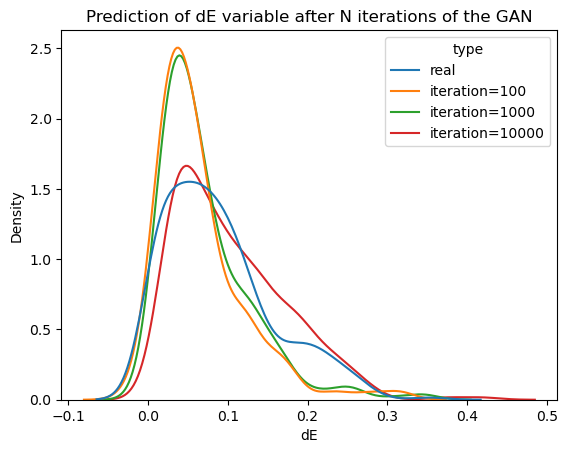

In [115]:
title = 'Prediction of dE variable after N iterations of the GAN'
sns.kdeplot(data=tips, x="dE", hue="type").set(title=title)

We clearly see the convergence of the network toward the variable distribution. For few iteration, the generator present a normal distribution due to noise initialization. We also observed that the convergence is very different from one launch to another